In [3]:
#BIG DATA - S&P500 PRICE FORECASTING, U.S. FINANCIAL NEWS SENTIMENT ANALYSIS


#THE NOTEBOOK/IDE USED FOR THIS PROJECT IS KAGGLE-BASED. IF THE NOTEBOOK IS RUN
#ON DIFFERENT IDEs,REMEMBER TO CHANGE THE PATH FOR THE WORKING DIRECTORY TO IMPORT .CSV FILES.

#Packages required to run the code
!pip install pmdarima statsmodels finnhub-python transformers torch huggingface_hub[hf_xet]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.8 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found ex

In [29]:
# Importing essential libraries for HTTP request, Json parsing, data manipulation,
#time-series analysis, modeling, evaluation, and plotting, while suppressing warnings/
#It also fetches the full daily price data for S&P500 (SPY) from Alpha Vantage API, raising 
#an error if the fetch fails.
#Lastly, it converts the Json into a sorted pandas Dataframe, then exports the full series to 
#spy_daily_raw.csv, and the closing prices to spy_daily_close.csv
import urllib.request
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import jarque_bera


warnings.filterwarnings("ignore")

API_KEY = "VAPMZYMOTGTQ5U1U"
url = (
    f"https://www.alphavantage.co/query?"
    f"function=TIME_SERIES_DAILY&symbol=SPY&outputsize=full&apikey={API_KEY}"
)
with urllib.request.urlopen(url) as resp:
    data = json.loads(resp.read().decode('utf-8')).get("Time Series (Daily)", {})
if not data:
    raise RuntimeError("Failed to fetch daily data from Alpha Vantage.")

df = pd.DataFrame.from_dict(data, orient='index', dtype=float)

df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

df.to_csv("spy_daily_raw.csv", index=True)

df_close = df['4. close'].copy()
df_close.to_csv("spy_daily_close.csv", header=["close"])

In [30]:
df = pd.read_csv("spy_daily_close.csv")
df

,Unnamed: 0,close
0,1999-11-01,135.5625
1,1999-11-02,134.5937
2,1999-11-03,135.5000
3,1999-11-04,136.5312
4,1999-11-05,137.8750
...,...,...
6421,2025-05-13,586.8400
6422,2025-05-14,587.5900
6423,2025-05-15,590.4600
6424,2025-05-16,594.2000


In [31]:
#Here the first column is renamed to "date", parsing it as datetime and making it the 
#dataframe's index
first_col = df.columns[0]
df.rename(columns={ first_col: "date" }, inplace=True)

df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

print(df.tail())

             close
date              
2025-05-13  586.84
2025-05-14  587.59
2025-05-15  590.46
2025-05-16  594.20
2025-05-19  594.85


In [32]:
null_values = df.isnull().sum()
print(null_values)

close    0
dtype: int64


In [33]:
df.sample(5)

,close
date,
2011-10-18,122.58
2009-05-21,89.21
2009-10-01,102.97
2023-05-09,410.93
2016-07-19,216.19


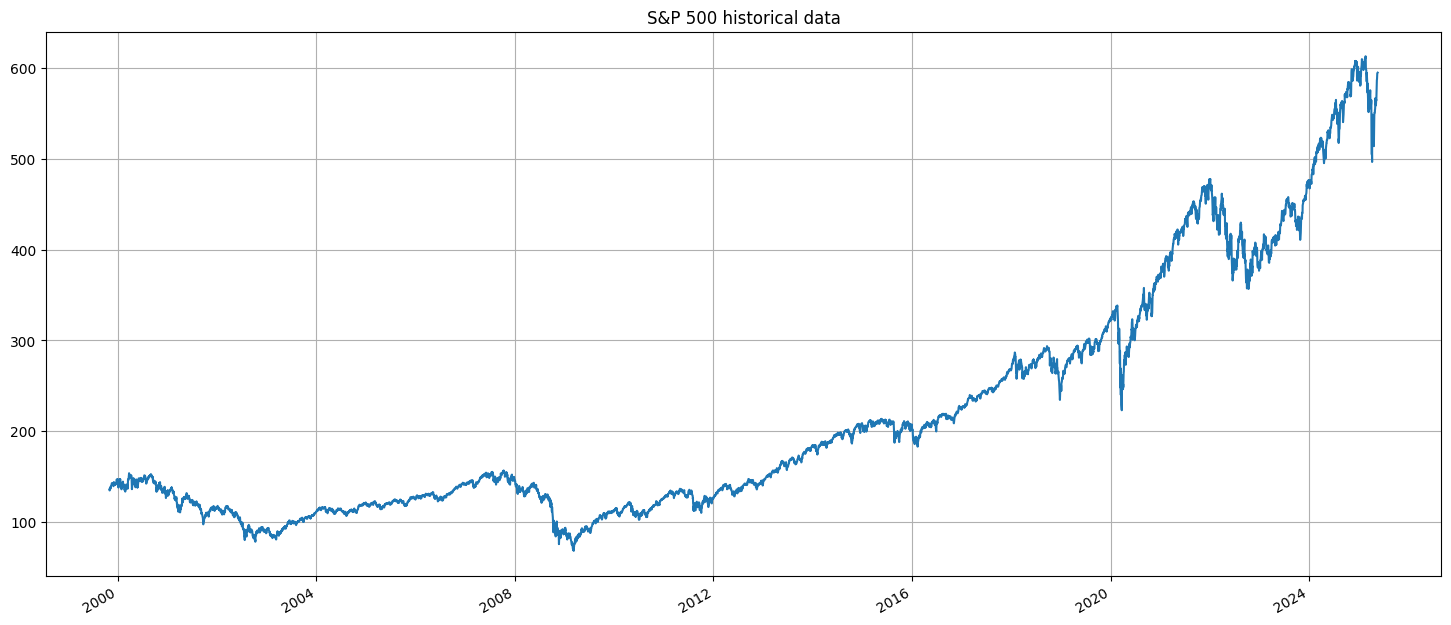

In [34]:
df_close.plot(figsize=(18,8))
plt.title('S&P 500 historical data')
plt.grid(True)

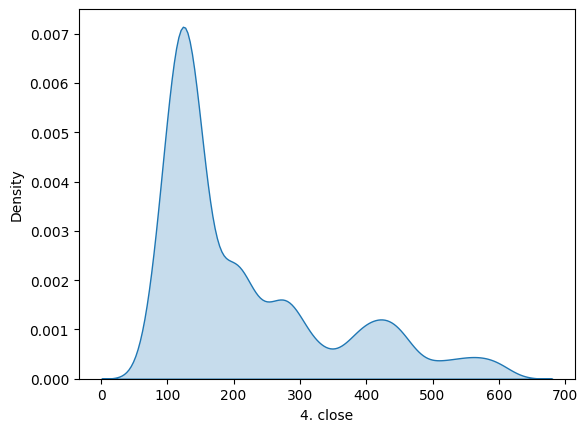

In [35]:
import seaborn as sns
sns.kdeplot(df_close, shade = True)
plt.show()

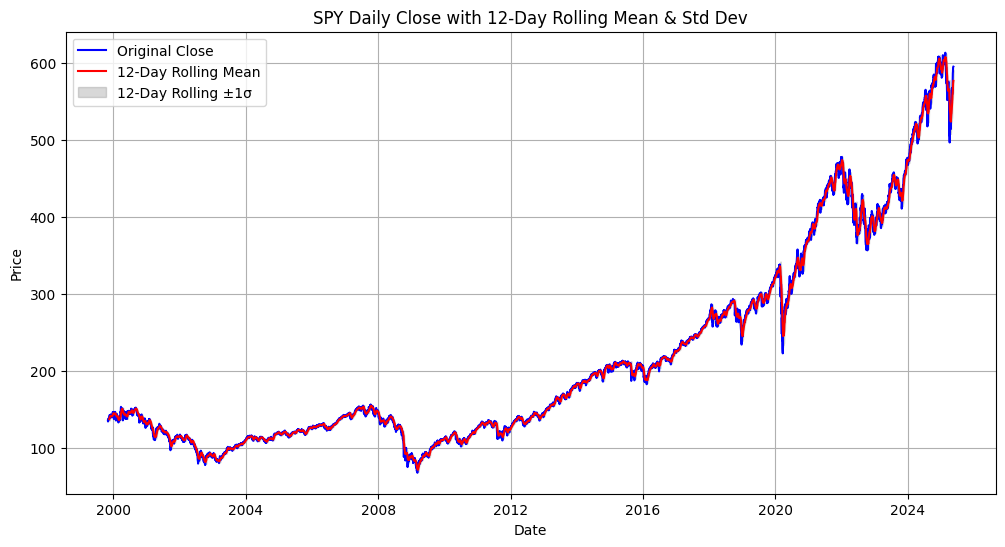

In [37]:
# Computing a 12-day rolling mean and standard deviation, then plot the original series with the 
#rolling mean and a shaded ±1σ band to highlight its variability over time
series = df['close'].asfreq('B').ffill()
window = 12
roll_mean = series.rolling(window=window).mean()
roll_std  = series.rolling(window=window).std()

plt.figure(figsize=(12,6))
plt.plot(series.index, series,label='Original Close', color='blue')
plt.plot(roll_mean.index, roll_mean, label=f'{window}-Day Rolling Mean', color='red')
plt.fill_between(
    roll_mean.index,
    roll_mean - roll_std,
    roll_mean + roll_std,
    color='gray',
    alpha=0.3,
    label=f'{window}-Day Rolling ±1σ'
)
plt.title(f'SPY Daily Close with {window}-Day Rolling Mean & Std Dev')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

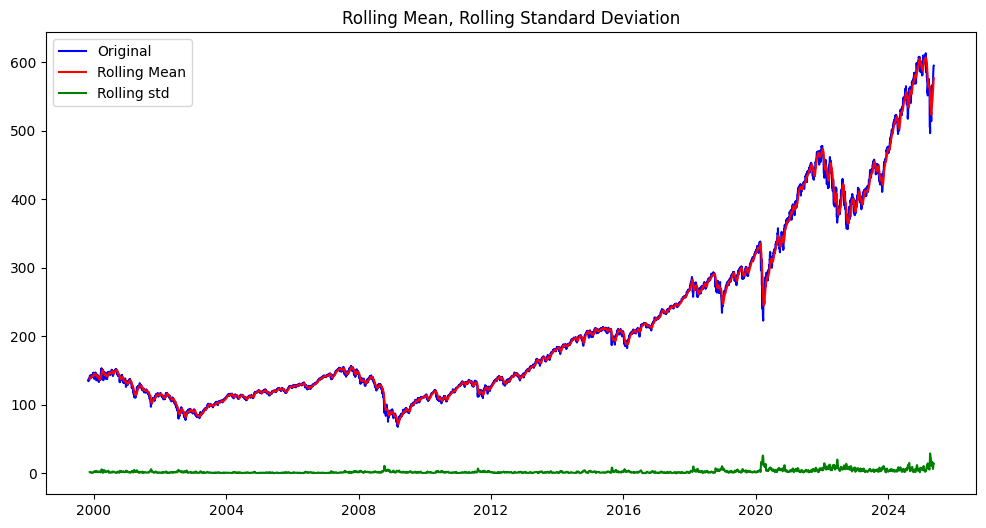

results of dickey-Fuller test:
Test Statistics            2.226745
p-value                    0.998904
No. of lags used          32.000000
No. of observations     6393.000000
Critical value (1%)       -3.431373
Critical value (5%)       -2.861992
Critical value (10%)      -2.567011
dtype: float64


In [38]:
# Compute and plot rolling statistics, then running the Dickey-Fuller test to evaluate the series’ stationarity
def test_stationarity(time_series):
    rol_mean = time_series.rolling(window = window).mean()
    rol_std = time_series.rolling(window = window).std()
    plt.figure(figsize = (12,6))
    plt.plot(time_series, color = 'blue', label = 'Original')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color = 'green', label = 'Rolling std')
    plt.legend(loc = 'best')
    plt.title("Rolling Mean, Rolling Standard Deviation")
    plt.show()

    print("results of dickey-Fuller test:")
    adft = adfuller(time_series, autolag = 'AIC')
    output = pd.Series(adft[0:4], index = ['Test Statistics', 'p-value', 'No. of lags used', 'No. of observations'])
    
    for key, value in adft[4].items():
        output['Critical value (%s)' % key] = value
    print(output)
test_stationarity(df_close)

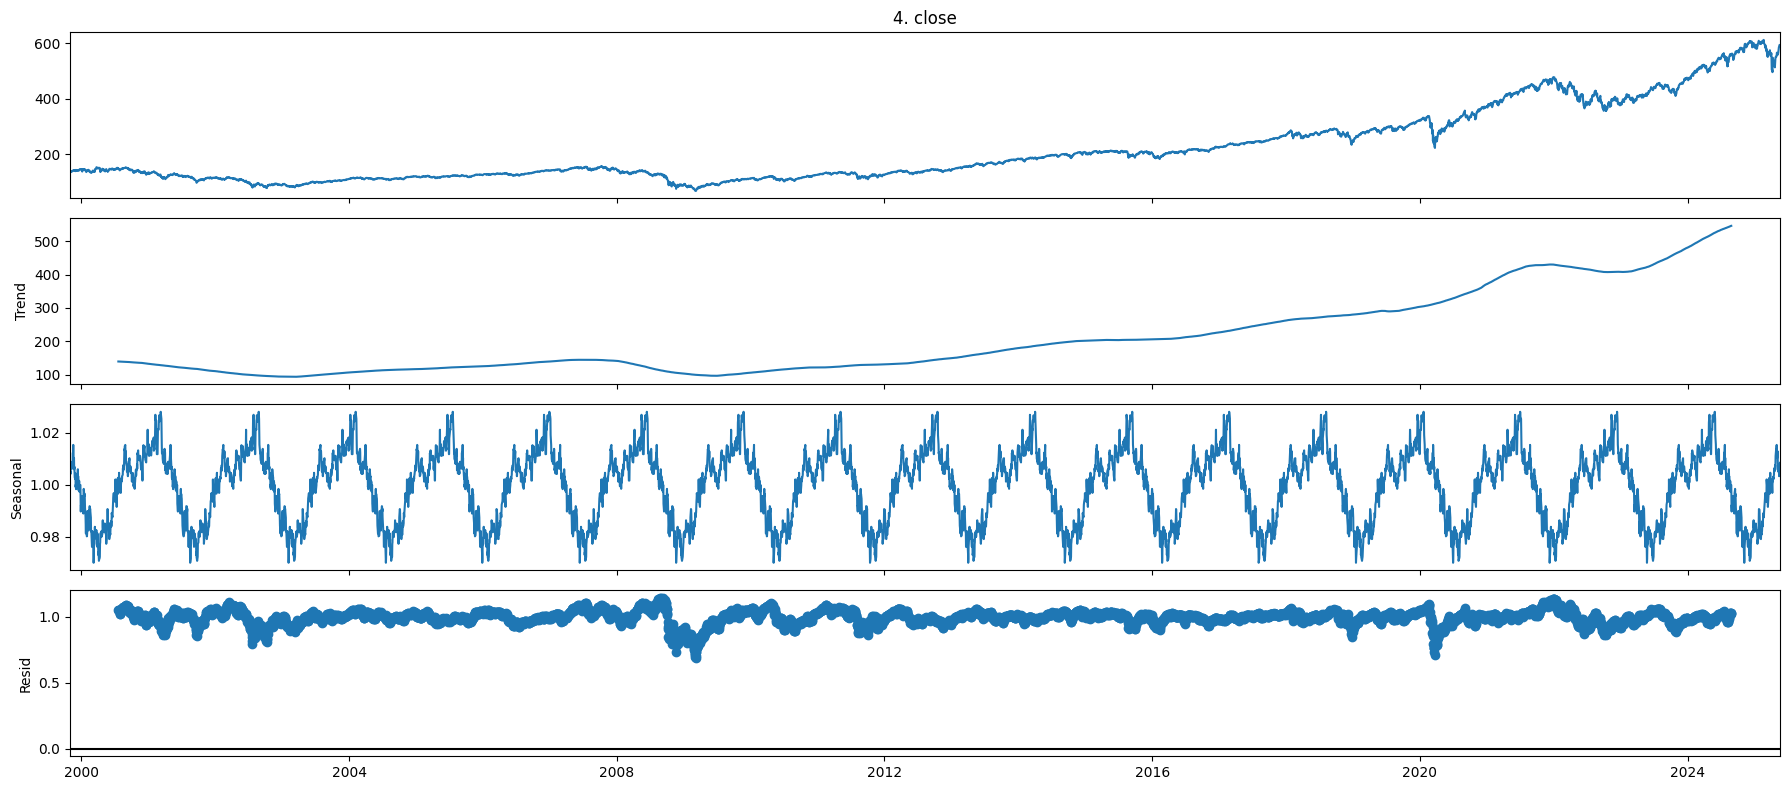

In [39]:
# Performing multiplicative seasonal decomposition with a 365-day period, then plotting its components, and computing the first-order difference of the series
result = seasonal_decompose(df_close, model = 'multiplicative', period = 365)

with plt.rc_context({'figure.figsize': (18,8)}):
    fig = result.plot()
df_close_differ = df_close.diff().dropna()

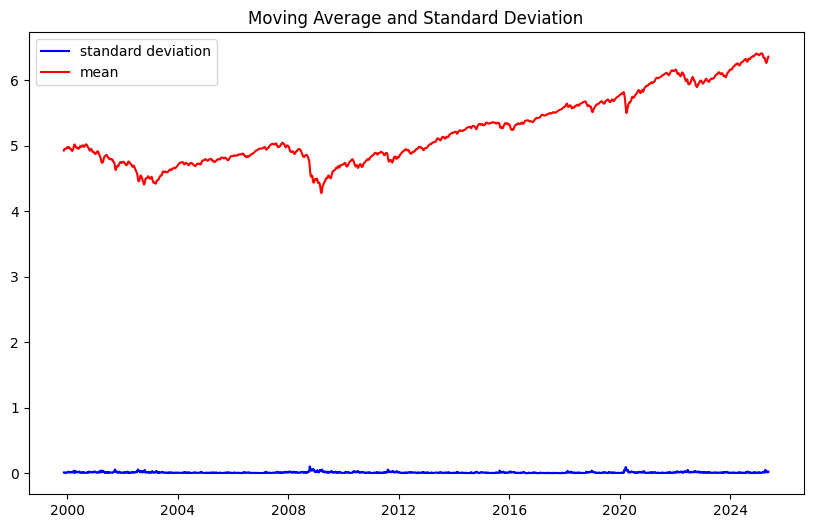

In [40]:
plt.figure(figsize =(10, 6))
df_log = np.log(df_close)

moving_avg = df_log.rolling(window).mean()
std_dev = df_log.rolling(window).std()
plt.plot(std_dev, color = 'blue', label = 'standard deviation')
plt.plot(moving_avg, color = 'red', label = "mean")
plt.legend(loc = 'best')
plt.title('Moving Average and Standard Deviation')
plt.show()

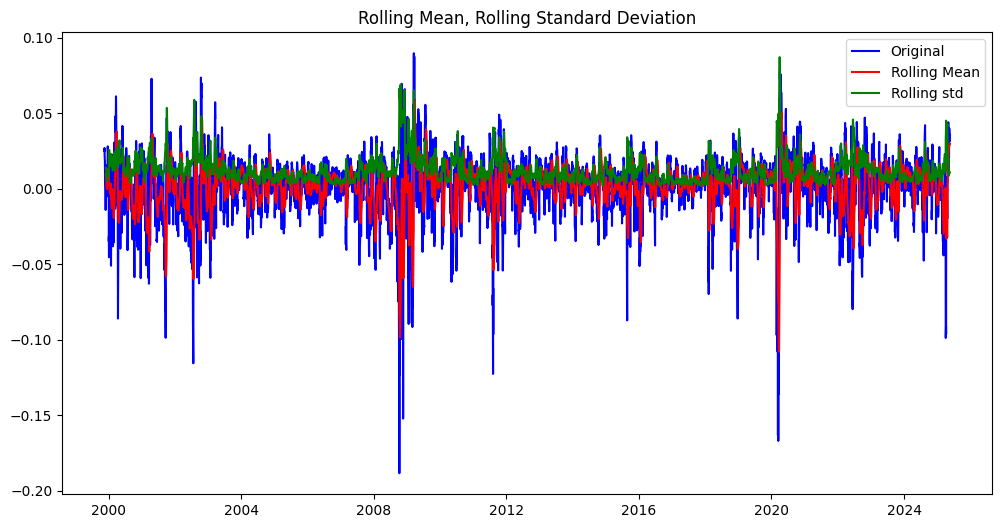

results of dickey-Fuller test:
Test Statistics        -1.752257e+01
p-value                 4.277862e-30
No. of lags used        1.600000e+01
No. of observations     6.398000e+03
Critical value (1%)    -3.431372e+00
Critical value (5%)    -2.861992e+00
Critical value (10%)   -2.567011e+00
dtype: float64


In [41]:
# Removing trend from the log-transformed series by subtracting its moving average, dropping NaNs, and assessing stationarity

log_min_mean = df_log - moving_avg
log_min_mean.dropna(inplace = True)
test_stationarity(log_min_mean)

In [42]:
# Automatically determines and fits the optimal non-seasonal ARIMA(p,d,q) model (with p and q up to 3) on the 
#log-transformed series, then it extracts its order

model = auto_arima(df_log, 
                   start_p = 1, 
                   start_q = 1, 
                   max_p = 3, 
                   max_q = 3, 
                   m = 1, 
                   start_P = 0,
                   seasonal = False, d = None, D = None, trace = True,
                   error_action = "ignore", suppress_warnings = True, stepwise = True
                  )
order = model.order

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-38306.557, Time=1.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38259.571, Time=0.67 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-38303.503, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-38305.574, Time=2.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38259.328, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-38304.529, Time=1.90 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-38306.126, Time=3.61 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-38305.974, Time=4.70 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-38305.453, Time=1.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-38304.013, Time=3.70 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-38305.661, Time=0.59 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 21.244 seconds


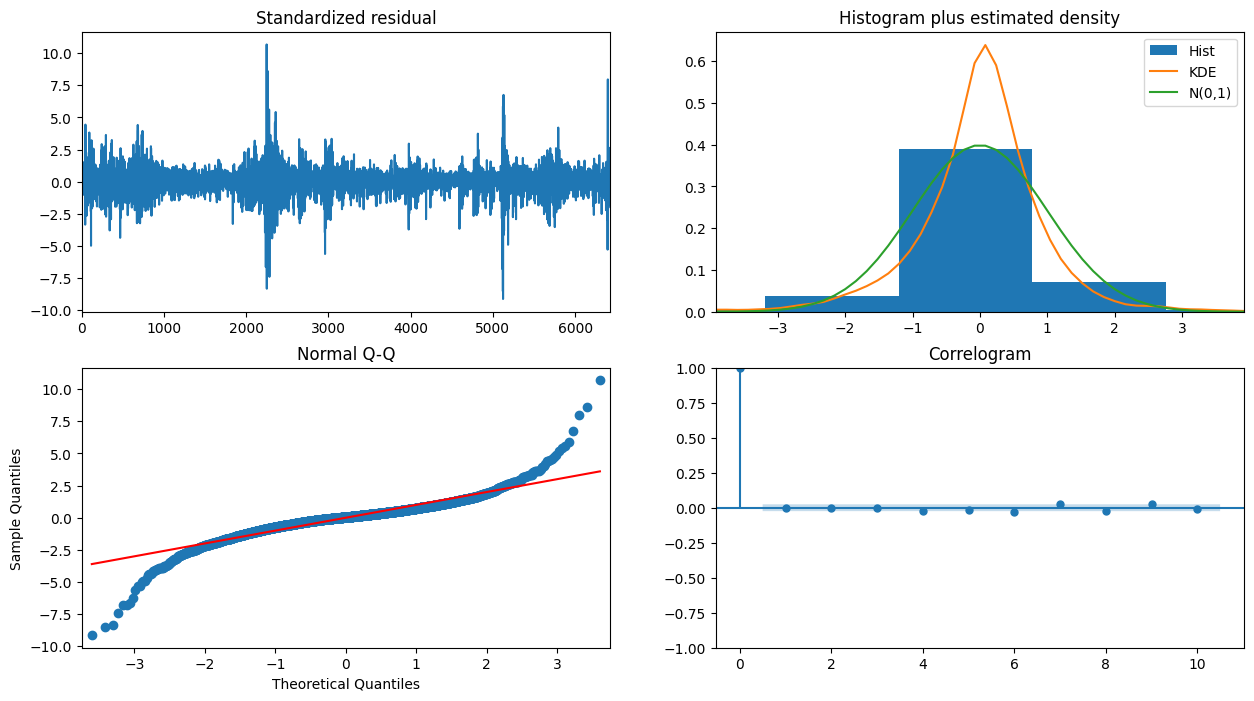

In [43]:
model.plot_diagnostics(figsize = (15, 8))
plt.show()

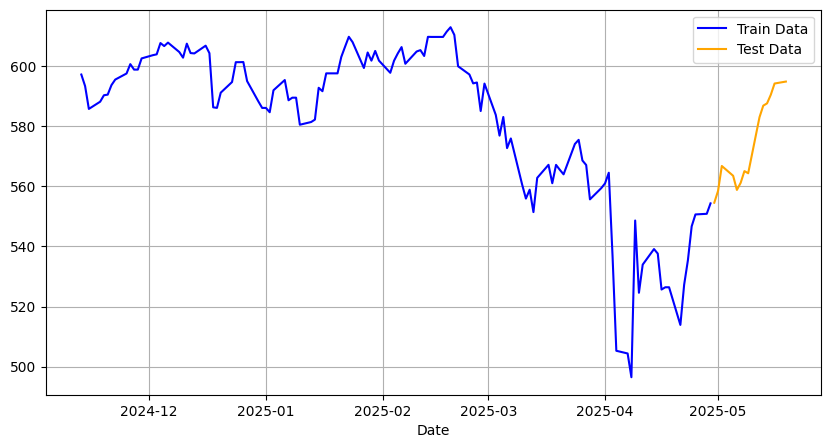

In [44]:
# Resamples "close" prices to business-day frequency with forward filling, splits into a 120-day training period and 14-day test period, and plots both sets
daily_close = df['close'].asfreq('B').ffill()

t_history = 120
t_horizon = 14
train = series[-(t_history + t_horizon):-t_horizon]
test  = series[-t_horizon:]

plt.figure(figsize = (10, 5), dpi = 100)
plt.grid(True)
plt.xlabel("Date")
plt.plot(train, 'blue', label = "Train Data")
plt.plot(test, 'orange', label = "Test Data")
plt.legend()


In [45]:
# Fitting the best performing SARIMAX(1,1,1) model with a constant trend to the training set (without enforcing stationarity/invertibility) 
#and prints its summary

model_lvl = SARIMAX(
    train,
    order=(1, 1, 1),
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False,
    freq=train.index.freq
)
res_lvl = model_lvl.fit(disp=False)
print(res_lvl.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  120
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -416.584
Date:                Tue, 20 May 2025   AIC                            841.167
Time:                        14:43:00   BIC                            852.216
Sample:                    11-13-2024   HQIC                           845.653
                         - 04-29-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.4076      1.137     -0.359      0.720      -2.636       1.820
ar.L1         -0.4726      0.639     -0.740      0.460      -1.725       0.780
ma.L1          0.3285      0.673      0.488      0.6

In [46]:
# the same steps on Log-transformed training data are applied: fitting a SARIMAX(1,1,1) model with constant trend, and printing the summary

train_log = np.log(train)
model_log = SARIMAX(
    train_log,
    order=(1, 1, 1),
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False,
    freq=train_log.index.freq
)
res_log = model_log.fit(disp=False)
print(res_log.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  120
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 320.507
Date:                Tue, 20 May 2025   AIC                           -633.014
Time:                        14:43:08   BIC                           -621.965
Sample:                    11-13-2024   HQIC                          -628.528
                         - 04-29-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0007      0.002     -0.342      0.733      -0.005       0.003
ar.L1         -0.4992      0.565     -0.884      0.377      -1.606       0.608
ma.L1          0.3480      0.599      0.581      0.5

In [47]:
# Generate t_horizon-step forecasts and confidence intervals from both level and log SARIMAX models, 
#index the predictions on business days, and exponentiate the log-forecasts to return to original scale

fc_lvl = res_lvl.get_forecast(steps=t_horizon)
pred_lvl = fc_lvl.predicted_mean
ci_lvl   = fc_lvl.conf_int()
tgt_idx = pd.bdate_range(start=train.index[-1] + BDay(1), periods=t_horizon)
fc_log = res_log.get_forecast(steps=t_horizon).predicted_mean
pred_log = np.exp(fc_log)
ci_log = res_log.get_forecast(steps=t_horizon).conf_int()
ci_lower_log = np.exp(ci_log.iloc[:, 0])
ci_upper_log = np.exp(ci_log.iloc[:, 1])

In [48]:
# Computes RMSE, MAE, MAPE for ARIMA forecasts vs test and naive baseline, 
#and calculate Theil's U (ARIMA RMSE / naive RMSE; <1 means the model beats the naive forecast)
def metrics(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae  = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return rmse, mae, mape

rmse_lvl, mae_lvl, mape_lvl = metrics(test, pred_lvl)
rmse_log, mae_log, mape_log = metrics(test, pred_log)
naive_pred = pd.Series([train.iloc[-1]] * t_horizon, index=test.index)
rmse_nv, mae_nv, mape_nv = metrics(test, naive_pred)
theils_u = rmse_lvl / rmse_nv

print(f"Price-level ARIMA RMSE: {rmse_lvl:.2f}, MAE: {mae_lvl:.2f}, MAPE: {mape_lvl:.2f}%")
print(f"Log-level  ARIMA RMSE: {rmse_log:.2f}, MAE: {mae_log:.2f}, MAPE: {mape_log:.2f}%")
print(f"Naive      RMSE: {rmse_nv:.2f}, MAE: {mae_nv:.2f}, MAPE: {mape_nv:.2f}%")
print(f"Theil's U (lvl): {theils_u:.3f} (<1 better)")


Price-level ARIMA RMSE: 26.58, MAE: 21.66, MAPE: 3.71%
Log-level  ARIMA RMSE: 26.53, MAE: 21.62, MAPE: 3.71%
Naive      RMSE: 24.00, MAE: 19.22, MAPE: 3.29%
Theil's U (lvl): 1.108 (<1 better)


In [49]:
# Testing the model residuals for autocorrelation (Ljung-Box), normality (Jarque-Bera), heteroscedasticity (ARCH), and displaying ARIMA parameter p-values

resid = res_log.resid
print("Ljung-Box p-value:", acorr_ljungbox(resid, lags=[10], return_df=True).lb_pvalue.iloc[0])
print("Jarque-Bera p-value:", jarque_bera(resid)[1])
print("ARCH p-value:", het_arch(resid)[3])
print("ARIMA log-model p-values:\n", res_log.pvalues)

Ljung-Box p-value: 0.7506957506294721
Jarque-Bera p-value: 0.0
ARCH p-value: 0.005912503249928924
ARIMA log-model p-values:
 intercept    7.326647e-01
ar.L1        3.768664e-01
ma.L1        5.612632e-01
sigma2       2.511835e-78
dtype: float64


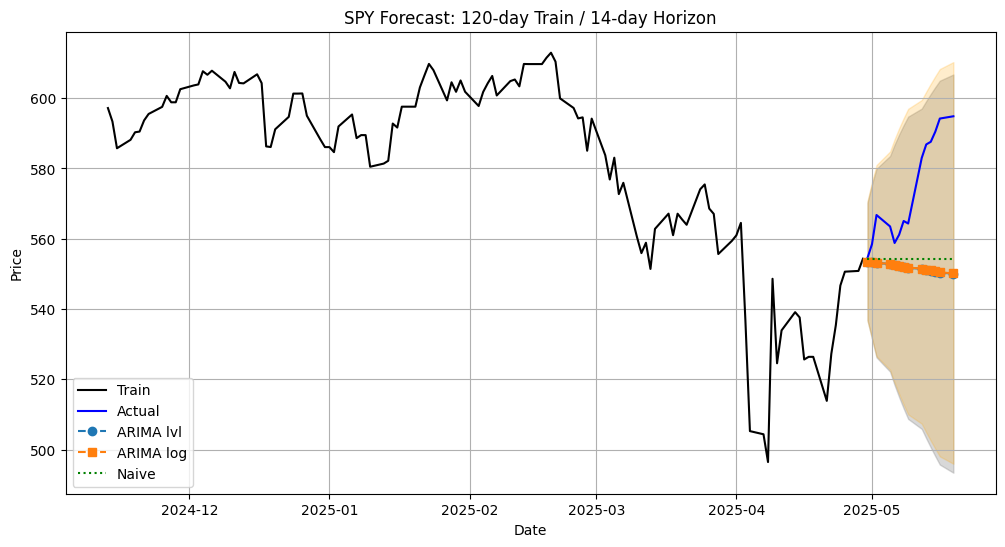

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='black')
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(pred_lvl.index, pred_lvl, 'o--', label='ARIMA lvl')
plt.fill_between(pred_lvl.index, ci_lvl.iloc[:,0], ci_lvl.iloc[:,1], color='gray', alpha=0.3)
plt.plot(pred_log.index, pred_log, 's--', label='ARIMA log')
plt.fill_between(pred_log.index, ci_lower_log, ci_upper_log, color='orange', alpha=0.2)
plt.plot(naive_pred.index, naive_pred, ':', color='green', label='Naive')
plt.title(f"SPY Forecast: {t_history}-day Train / {t_horizon}-day Horizon")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# Generates forecasts for the next `horizon_days` from the fitted model, retrieving both the predicted mean values and their confidence intervals

forecast_obj = res_lvl.get_forecast(steps=t_horizon)
price_pred = forecast_obj.predicted_mean
ci = forecast_obj.conf_int()



In [56]:
#Here there is an evaluation of ARIMA vs naive forecast (RMSE, MAE, MAPE), and a computation of Theil's U.
#additionally, a resudual diagnostic is ran(Ljung-Box, Jarque-Bera, ARCH), printing p-values and model parameter p-values
rmse_price = np.sqrt(mean_squared_error(test, price_pred))
mae_price  = mean_absolute_error(test, price_pred)
mape_price = np.mean(np.abs((test - price_pred) / test)) * 100
print(f"Price-level {t_horizon}-day ARIMA RMSE: {rmse_price:.2f}, MAE: {mae_price:.2f}, MAPE: {mape_price:.2f}%")

naive_pred = pd.Series([train.iloc[-1]] * t_horizon, index=test.index)
rmse_naive = np.sqrt(mean_squared_error(test, naive_pred))
mae_naive  = mean_absolute_error(test, naive_pred)
mape_naive = np.mean(np.abs((test - naive_pred) / test)) * 100
print(f"Price-level {t_horizon}-day Naive RMSE: {rmse_naive:.2f}, MAE: {mae_naive:.2f}, MAPE: {mape_naive:.2f}%")

theil_u = np.sqrt(rmse_price**2 / rmse_naive**2)
print(f"Theil's U: {theil_u:.3f}    (U < 1 ⇒ ARIMA beats naive)")


resid = res_lvl.resid
lb_p = acorr_ljungbox(resid, lags=[10], return_df=True).lb_pvalue.iloc[0]
jb_p = jarque_bera(resid)[1]
arch_p = het_arch(resid)[3]
print(f"Ljung-Box p-value: {lb_p:.3f} (>0.05 OK)")
print(f"Jarque-Bera p-value: {jb_p:.3f} (>0.05 OK)")
print(f"ARCH p-value: {arch_p:.3f} (>0.05 OK)")
print("Model p-values:\n", res_lvl.pvalues)

Price-level 14-day ARIMA RMSE: 26.58, MAE: 21.66, MAPE: 3.71%
Price-level 14-day Naive RMSE: 24.00, MAE: 19.22, MAPE: 3.29%
Theil's U: 1.108    (U < 1 ⇒ ARIMA beats naive)
Ljung-Box p-value: 0.852 (>0.05 OK)
Jarque-Bera p-value: 0.000 (>0.05 OK)
ARCH p-value: 0.006 (>0.05 OK)
Model p-values:
 intercept    7.198955e-01
ar.L1        4.595150e-01
ma.L1        6.252388e-01
sigma2       4.645867e-70
dtype: float64


In [63]:
fc = res_lvl.get_forecast(steps=t_horizon)
fc_diff = fc.predicted_mean.values            # shape (t_horizon,)
              
ci = fc.conf_int()  
ci_lower = ci.iloc[:, 0].values   # 1-D numpy array of all the lower bounds  
ci_upper = ci.iloc[:, 1].values 

In [64]:
last_train_price = train.iloc[-1]
price_pred  = last_train_price + np.cumsum(fc_diff) 

In [68]:
# Forecast of future values by obtaining predicted differences, reconstructing price-level forecasts via cumulative summation from the last training price, and then directly extracting the model’s predicted means

fc_diff = res_lvl.get_forecast(steps=t_horizon).predicted_mean
last_train_price = train.iloc[-1]
actual_prices = test.values
price_pred = last_train_price + np.cumsum(fc_diff.values) 
fc = res_lvl.get_forecast(steps=t_horizon)
price_pred = fc.predicted_mean.values


In [70]:
actual_diffs = np.diff(np.concatenate([[last_train_price], actual_prices]))


In [71]:
# Calculating RMSE and MAE by comparing the actual vs. predicted daily differences over the 7-day horizon

pred_diffs   = np.diff(np.concatenate([[train.iloc[-1]], price_pred]))
rmse_diff = np.sqrt(mean_squared_error(actual_diffs, pred_diffs))
mae_diff  = mean_absolute_error(actual_diffs, pred_diffs)
print(f"Diff-level 7-day RMSE:  {rmse_diff:.4f}, MAE: {mae_diff:.4f}")

Diff-level 7-day RMSE:  6.2598, MAE: 4.3234


In [72]:
## Importing libraries for numeric and dataframe operations, 
#date/time handling, HTTP requests and web scraping, financial API access, 
#regex parsing, and NLP model inference with PyTorch

import numpy as np
import pandas as pd
from datetime import date
from datetime import datetime, timedelta
import requests
import finnhub
import re
from bs4 import BeautifulSoup
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

In [73]:
# Initializing Finnhub client, iterating over a list of tickers to fetch company news in the given date range,
#storing each in a DataFrame, and printing the datetime and headline of the first entries

finnhub_client = finnhub.Client(api_key="d0741o1r01qrslhm0m10d0741o1r01qrslhm0m1g")


tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NFLX', 'TSLA', 'NVDA', 'IBM', 'JPM', 'BAC',
          'GS', 'WFC', 'XOM', 'CVX', 'SPY', 'QQQ', 'DIA', 'IWM', 'GE', 'DUK', 'NEE']

date_from = "2025-01-01"
date_to = "2025-05-20"

news_dataframes = {}

for ticker in tickers:
    print(f"\nFetching news for: {ticker}")
    
    try:
        news = finnhub_client.company_news(ticker, _from=date_from, to=date_to)
        
        if news:
            df = pd.DataFrame(news)
            news_dataframes[ticker] = df

            if 'datetime' in df.columns and 'headline' in df.columns:
                print(df[['datetime', 'headline']].head())
            else:
                print("Fetched news, but 'datetime' or 'headline' columns not found.")
        else:
            print(f"No news found for {ticker} in given date range.")

    except Exception as e:
        print(f"Error fetching news for {ticker}: {e}")



Fetching news for: AAPL
     datetime                                           headline
0  1747748651  Apple Partner Foxconn Taps India With Massive ...
1  1747748515  Amer Sports, General Motors, Apple: Trending T...
2  1747748103  Alphabet Traders Look to Developer Event to Sh...
3  1747745069  Cloud AI Today - Azure Managed Redis Boosts Pe...
4  1747736520  Janus Henderson Global Sustainable Equity (ADR...

Fetching news for: MSFT
     datetime                                           headline
0  1747748677  Microsoft (MSFT) Fell on Potential Competition...
1  1747745069  Cloud AI Today - Azure Managed Redis Boosts Pe...
2  1747742400  Tariff-Driven Dollar Woes Help Brighten First-...
3  1747737933  Steve Ballmer Once Said This About Being A Bil...
4  1747736520  Janus Henderson Global Sustainable Equity (ADR...

Fetching news for: GOOGL
     datetime                                           headline
0  1747748103  Alphabet Traders Look to Developer Event to Sh...
1  1747747927 

In [74]:
#The same process is done, with different time range to avoid API scraping limitations.
finnhub_client = finnhub.Client(api_key="d0741o1r01qrslhm0m10d0741o1r01qrslhm0m1g")

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NFLX', 'TSLA', 'NVDA', 'IBM', 'JPM', 'BAC',
          'GS', 'WFC', 'XOM', 'CVX', 'SPY', 'QQQ', 'DIA', 'IWM', 'GE', 'DUK', 'NEE']

date_from = "2024-01-01"
date_to = "2024-12-31"

news2_dataframes = {}

for ticker in tickers:
    print(f"\nFetching news for: {ticker}")
    
    try:
        news2 = finnhub_client.company_news(ticker, _from=date_from, to=date_to)
        
        if news2:
            df = pd.DataFrame(news2)
            news2_dataframes[ticker] = df

            if 'datetime' in df.columns and 'headline' in df.columns:
                print(df[['datetime', 'headline']].head())
            else:
                print("Fetched news, but 'datetime' or 'headline' columns not found.")
        else:
            print(f"No news found for {ticker} in given date range.")

    except Exception as e:
        print(f"Error fetching news for {ticker}: {e}")


Fetching news for: AAPL
     datetime                                           headline
0  1735679580     Stocks Cap Best Two Years in a Quarter-Century
1  1735646772  These 10 Stocks Called 'Tech Winners For The A...
2  1735675740  The Trillion Dollar Stock Club Is Bigger—and R...
3  1735667400  1 Way the Magnificent 7 Stocks Disappointed in...
4  1735666201       2024 Stock Market News: The Year At A Glance

Fetching news for: MSFT
     datetime                                           headline
0  1735679580     Stocks Cap Best Two Years in a Quarter-Century
1  1735646772  These 10 Stocks Called 'Tech Winners For The A...
2  1735667400  1 Way the Magnificent 7 Stocks Disappointed in...
3  1735658114  Nvidia, Microsoft Expected to Lead AI Growth i...
4  1735654802  Wedbush: Nvidia and Microsoft to Lead Explosiv...

Fetching news for: GOOGL
     datetime                                           headline
0  1735679580     Stocks Cap Best Two Years in a Quarter-Century
1  1735665939 

In [75]:
# Adding a 'ticker' column to each news DataFrame, concatenating them all into one DataFrame, and printing the first few rows
# The process is done for both dataframes

combined_df = pd.concat(news_dataframes.values(), ignore_index=True)

for ticker, df in news_dataframes.items():
    df['ticker'] = ticker

combined_df = pd.concat(news_dataframes.values(), ignore_index=True)

print(combined_df.head())

  category    datetime                                           headline  \
0  company  1747748651  Apple Partner Foxconn Taps India With Massive ...   
1  company  1747748515  Amer Sports, General Motors, Apple: Trending T...   
2  company  1747748103  Alphabet Traders Look to Developer Event to Sh...   
3  company  1747745069  Cloud AI Today - Azure Managed Redis Boosts Pe...   
4  company  1747736520  Janus Henderson Global Sustainable Equity (ADR...   

          id                                              image related  \
0  134608919  https://s.yimg.com/rz/stage/p/yahoo_finance_en...    AAPL   
1  134608920  https://s.yimg.com/rz/stage/p/yahoo_finance_en...    AAPL   
2  134608921  https://s.yimg.com/rz/stage/p/yahoo_finance_en...    AAPL   
3  134608889  https://s.yimg.com/rz/stage/p/yahoo_finance_en...    AAPL   
4  134610241  https://static.seekingalpha.com/cdn/s3/uploads...    AAPL   

         source                                            summary  \
0         Yahoo 

In [76]:
combined_df2 = pd.concat(news2_dataframes.values(), ignore_index=True)

for ticker, df in news2_dataframes.items():
    df['ticker'] = ticker

combined_df2 = pd.concat(news2_dataframes.values(), ignore_index=True)

print(combined_df2.head())

  category    datetime                                           headline  \
0  company  1735679580     Stocks Cap Best Two Years in a Quarter-Century   
1  company  1735646772  These 10 Stocks Called 'Tech Winners For The A...   
2  company  1735675740  The Trillion Dollar Stock Club Is Bigger—and R...   
3  company  1735667400  1 Way the Magnificent 7 Stocks Disappointed in...   
4  company  1735666201       2024 Stock Market News: The Year At A Glance   

          id                                              image related  \
0  132218950                                                       AAPL   
1  132213891                                                       AAPL   
2  132219160  https://media.zenfs.com/en/Barrons.com/12ea0f4...    AAPL   
3  132217242                                                       AAPL   
4  132320930                                                       AAPL   

     source                                            summary  \
0     Yahoo  Some in

In [77]:
# Normalize epoch timestamps to datetime (seconds since epoch), filter out rows before 2000-01-01, then combine and report

def normalize_epoch_datetime(df, col='datetime', cutoff='2000-01-01'):
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = pd.to_datetime(df[col], unit='s', errors='coerce')
    df = df.loc[df[col].ge(pd.Timestamp(cutoff))]
    return df

for d in (news_dataframes, news2_dataframes):
    for ticker, df in d.items():
        d[ticker] = normalize_epoch_datetime(df)

combined_df  = pd.concat(news_dataframes.values(),  ignore_index=True)
combined_df2 = pd.concat(news2_dataframes.values(), ignore_index=True)

for name, df in (('combined_df', combined_df), ('combined_df2', combined_df2)):
    print(f"{name}: {len(df)} rows, null datetimes = {df['datetime'].isna().sum()}")
    display(df[['datetime','ticker','headline']].head())


combined_df: 5003 rows, null datetimes = 0


,datetime,ticker,headline
0,2025-05-20 13:44:11,AAPL,Apple Partner Foxconn Taps India With Massive ...
1,2025-05-20 13:41:55,AAPL,"Amer Sports, General Motors, Apple: Trending T..."
2,2025-05-20 13:35:03,AAPL,Alphabet Traders Look to Developer Event to Sh...
3,2025-05-20 12:44:29,AAPL,Cloud AI Today - Azure Managed Redis Boosts Pe...
4,2025-05-20 10:22:00,AAPL,Janus Henderson Global Sustainable Equity (ADR...


combined_df2: 4995 rows, null datetimes = 0


,datetime,ticker,headline
0,2024-12-31 21:13:00,AAPL,Stocks Cap Best Two Years in a Quarter-Century
1,2024-12-31 12:06:12,AAPL,These 10 Stocks Called 'Tech Winners For The A...
2,2024-12-31 20:09:00,AAPL,The Trillion Dollar Stock Club Is Bigger—and R...
3,2024-12-31 17:50:00,AAPL,1 Way the Magnificent 7 Stocks Disappointed in...
4,2024-12-31 17:30:01,AAPL,2024 Stock Market News: The Year At A Glance


In [78]:
print(combined_df[['datetime', 'ticker', 'summary']])

                datetime ticker  \
0    2025-05-20 13:44:11   AAPL   
1    2025-05-20 13:41:55   AAPL   
2    2025-05-20 13:35:03   AAPL   
3    2025-05-20 12:44:29   AAPL   
4    2025-05-20 10:22:00   AAPL   
...                  ...    ...   
4998 2025-03-07 10:25:00    NEE   
4999 2025-03-07 04:35:00    NEE   
5000 2025-03-06 11:00:00    NEE   
5001 2025-03-05 09:00:00    NEE   
5002 2025-03-04 07:32:05    NEE   

                                                summary  
0     Foxconn's Bold ?127.7 Billion India Gamble as ...  
1     Amer Sports (AS) stock pops after beating firs...  
2     (Bloomberg) -- Alphabet Inc.’s investors are l...  
3     Microsoft has announced the general availabili...  
4     The Portfolio returned 1.05% (gross) and the M...  
...                                                 ...  
4998  The ClearBridge Tactical Dividend Income Strat...  
4999  During the fourth quarter, the ClearBridge Glo...  
5000  Want a reliable 10%+ yield? This portfolio del...  

In [80]:
combined_df2.to_csv("fin_news2.csv", index=False)
print(" Saved 'fin_news2.csv'.")
combined_df.to_csv("fin_news.csv", index = False)
print("Saved 'fin_news.csv'")


merged_df = pd.concat([combined_df, combined_df2], ignore_index=True)


merged_df.to_csv("merged_financial_news.csv", index=False)
print("Saved merged news as 'merged_financial_news.csv'.")

 Saved 'fin_news2.csv'.
Saved 'fin_news.csv'
Saved merged news as 'merged_financial_news.csv'.


In [81]:
cb_news = pd.read_csv("/kaggle/working/fin_news.csv")
#cb_news = pd.read_csv("/path/to/big_tech_news.csv")
cb2_news = pd.read_csv("/kaggle/working/fin_news2.csv")


In [82]:
# Computing and comparing the average word counts of headlines and summaries to determine which is generally longer, 
#and better to use for sentiment classification

df['headline_word_count'] = df['headline'].astype(str).apply(lambda x: len(x.split()))
df['summary_word_count']  = df['summary'].astype(str).apply(lambda x: len(x.split()))


avg_headline_len = df['headline_word_count'].mean()
avg_summary_len  = df['summary_word_count'].mean()

print(f"Average headline word count: {avg_headline_len:.2f}")
print(f"Average summary word count: {avg_summary_len:.2f}")

if avg_summary_len > avg_headline_len:
    print("Summaries are longer on average.")
elif avg_headline_len > avg_summary_len:
    print("Headlines are longer on average.")
else:
    print("Headlines and summaries are the same length on average.")



Average headline word count: 10.90
Average summary word count: 33.84
Summaries are longer on average.


In [83]:
# This function cleans news summaries: it strip HTML/URLs, removes unwanted chars, normalizes whitespace, parses timestamps, and drops duplicates to produce a final timestamped text dataset
#The same process is applied to both dataframes
def clean_text(text: str) -> str:
    text = BeautifulSoup(text, "html.parser").get_text()                
    text = re.sub(r"http\S+", "", text)                                
    text = re.sub(r"[^A-Za-z0-9\.\,\!\?\$\%\s]+", "", text)            
    text = re.sub(r"\s+", " ", text).strip()                           
    return text                                                
    
news_summary = cb_news.loc[
    cb_news['summary'].notnull() & cb_news['datetime'].notnull()].copy()
news_summary['datetime'] = pd.to_datetime(news_summary['datetime'], errors='coerce')
news_summary = news_summary.loc[news_summary['datetime'].notnull()]

news_summary.sort_values('datetime', ascending=True, inplace=True)

before = len(news_summary)
news_summary.drop_duplicates(subset=['summary'], keep='first', inplace=True)
print(f"Dropped {before - len(news_summary)} exact-summary duplicates.")

news_summary['cleaned_summary'] = news_summary['summary'].apply(clean_text)

before = len(news_summary)
news_summary.drop_duplicates(subset=['cleaned_summary'], keep='first', inplace=True)
print(f"Dropped {before - len(news_summary)} cleaned-summary duplicates.")

news_final = (
    news_summary
    .loc[:, ['datetime', 'cleaned_summary']]
    .rename(columns={'datetime': 'timestamp', 'cleaned_summary': 'text'})
    .reset_index(drop=True)
)
print(f"Final dataset contains {len(news_final)} unique articles.")

Dropped 1126 exact-summary duplicates.
Dropped 3 cleaned-summary duplicates.
Final dataset contains 3549 unique articles.


In [84]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  
    text = re.sub(r"http\S+", "", text)  
    text = re.sub(r"[^A-Za-z0-9.,!?$% ]+", "", text)  
    text = re.sub(r"\s+", " ", text).strip()  
    return text  
    
news2_summary = cb2_news[cb2_news['summary'].notnull() & cb2_news['datetime'].notnull()].copy()
news2_summary['datetime'] = pd.to_datetime(news2_summary['datetime'], errors='coerce')
news2_summary = news2_summary[news2_summary['datetime'].notnull()]

news2_summary.sort_values('datetime', ascending=True, inplace=True)

before = len(news2_summary)
news2_summary.drop_duplicates(subset=['summary'], keep='first', inplace=True)
print(f"Dropped {before - len(news2_summary)} exact-summary duplicates.")

news2_summary['cleaned_summary'] = news2_summary['summary'].apply(clean_text)

before = len(news2_summary)
news2_summary.drop_duplicates(subset=['cleaned_summary'], keep='first', inplace=True)
print(f"Dropped {before - len(news2_summary)} cleaned-summary duplicates.")

news2_final = (
    news2_summary
    [['datetime', 'cleaned_summary']]
    .rename(columns={
        'datetime': 'timestamp',
        'cleaned_summary': 'text'
    })
    .reset_index(drop=True)
)
print(f"Final dataset contains {len(news2_final)} unique articles.")

Dropped 1350 exact-summary duplicates.
Dropped 1 cleaned-summary duplicates.
Final dataset contains 3611 unique articles.


In [85]:
# Combininig both cleaned news datasets, removing duplicate articles, sorting by timestamp, and reindexing for final processing

news_full = pd.concat([news_final, news2_final], ignore_index=True)
news_full = (
    news_full
    .drop_duplicates(subset='text', keep='first')
    .sort_values(by='timestamp')
    .reset_index(drop=True)
)

print(f"Total articles to classify: {len(news_full)}")

Total articles to classify: 7095


In [86]:
# Loading the FinBERT tokenizer and pretrained sequence‐classification model for sentiment analysis, setting it to evaluation mode, and defining the mapping from output IDs to sentiment labels

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

label_map = {0: "negative", 1: "neutral", 2: "positive"}




tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

2025-05-20 15:06:59.930741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747753620.254247      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747753620.343266      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [87]:
# Tokenizes input text, runs it through FinBERT to get class logits, applies softmax, and returns the corresponding sentiment label

def classify_sentiment(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )
    with torch.no_grad():
        logits = model(**inputs).logits
        probs  = F.softmax(logits, dim=1)
        idx    = torch.argmax(probs, dim=1).item()
    return label_map[idx]

In [88]:
# Applying the FinBERT sentiment classifier to each article, to display the proportion of each sentiment, and save the labeled data to CSV

news_full['sentiment'] = news_full['text'].apply(classify_sentiment)


print(news_full['sentiment'].value_counts(normalize=True))


news_full.to_csv("sent_lab_sum.csv", index=False)

sentiment
positive    0.460888
negative    0.303735
neutral     0.235377
Name: proportion, dtype: float64


In [89]:
sentiment_df = pd.read_csv(
    "/kaggle/working/sent_lab_sum.csv",
    dtype={"sentiment": str}
)
sentiment_df["timestamp"] = sentiment_df["timestamp"].str.strip()

In [90]:
sentiment_df["timestamp"] = pd.to_datetime(
    sentiment_df["timestamp"],
    format="%Y-%m-%d %H:%M:%S",  
    errors="coerce"             
)


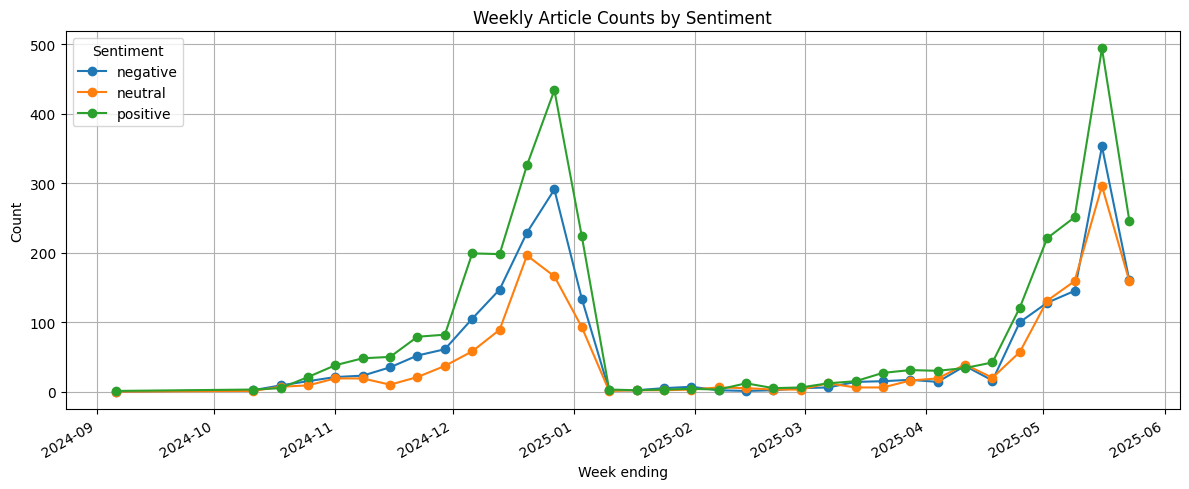

In [91]:
sentiment_df.set_index("timestamp", inplace=True)

weekly_counts = (
    sentiment_df
      .groupby([pd.Grouper(freq="W-FRI"), "sentiment"])
      .size()
      .unstack(fill_value=0)
)

weekly_counts.plot(figsize=(12,5), marker="o")
plt.title("Weekly Article Counts by Sentiment")
plt.xlabel("Week ending")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.grid(True)
plt.tight_layout()
plt.show()

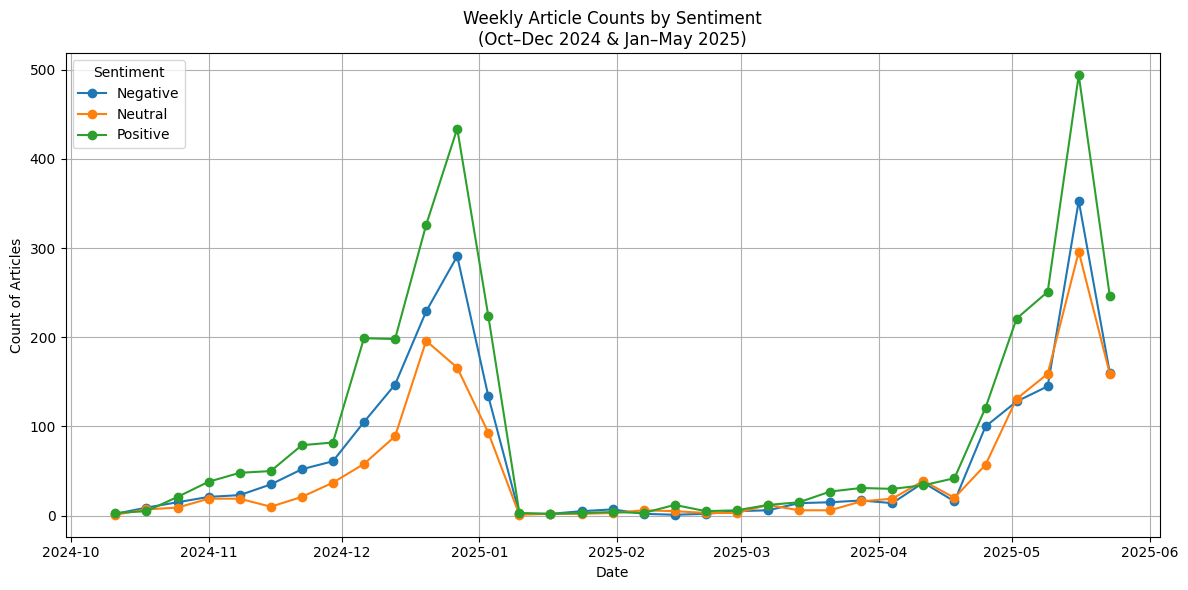

In [92]:
# this cell filters the weekly sentiment counts to Oct–Dec 2024 and Jan–May 2025, then plot each sentiment’s weekly article count over those periods


mask = (
    (weekly_counts.index >= "2024-10-01") & (weekly_counts.index <= "2024-12-31")
) | (
    (weekly_counts.index >= "2025-01-01") & (weekly_counts.index <= "2025-05-31")
)

filtered_counts = weekly_counts.loc[mask]

plt.figure(figsize=(12, 6))
for sentiment in filtered_counts.columns:
    plt.plot(
        filtered_counts.index,
        filtered_counts[sentiment],
        marker="o",
        label=sentiment.capitalize()
    )

plt.title("Weekly Article Counts by Sentiment\n(Oct–Dec 2024 & Jan–May 2025)")
plt.xlabel("Date")
plt.ylabel("Count of Articles")
plt.legend(title="Sentiment")
plt.grid(True)
plt.tight_layout()
plt.show()
